# Stochastic Simulation [5284STSI6Y]
# Assignment 2 - Discrete Event Simulation - Multiple Queues and Multiple Servers


- Jiawei Liao 14702398

- Weikang Chen 14765632

- Dan Dong 14989093

Faculty of Sicience, University of Amsterdam

December 02, 2023

In [1]:
! pip install simpy

Defaulting to user installation because normal site-packages is not writeable


**Import Packages**

In [1]:
import simpy
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

## Problem 2 - DES program to explore waiting time about M/M/n

#### Simulation for M/M/n:

In [2]:
from scipy import stats
# Set the print options to display all rows and columns
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def setup(env, num_servers, servicetime, Lambda, waiting_times):
    """
    Initializes the simulation environment and the customer arrival process.
    Args:
        env: Simulation environment.
        num_servers: Number of servers/resources available.
        servicetime: Average service time.
        Lambda: Rate of customer arrival.
        waiting_times: List to record waiting times of customers.
    """
    # Create server resources
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """ Service process using exponential distribution for service time. """
        yield env.timeout(np.random.exponential(servicetime))

    def customer(name):
        """ Customer arrival and service process. """
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # Record waiting time for each customer
            waiting_times.append(waiting_time)
    
    # Generate initial customer
    env.process(customer('Customer 0'))

    # Continuously generate customers
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    """
    Runs the simulation.
    Args:
        num_servers: Number of servers.
        rho: Traffic intensity.
        MU: Service rate.
        SIM_TIME: Simulation time.
        SIMULATIONS: Number of simulations to run.
    Returns:
        Tuple of data simulations and average waiting times.
    """
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # Arrival rate
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings

def perform_mann_whitney_u_test(data1, data2):
    """
    Performs the Mann-Whitney U test between two groups of data.
    Args:
        data1: First group of data.
        data2: Second group of data.
    Returns:
        U statistic and p-value.
    """
    u_statistic, p_value = mannwhitneyu(data1, data2, alternative='less')
    return u_statistic, p_value


**Calculate how the waiting time changes with the value of ρ when c is equal to 1, 2, and 4:**

In [4]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []
waiting_times_data = {rho: {1: [], 2: [], 4: []} for rho in RHO}

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })
        # Add waiting time data
        for wt in sim_data:
            waiting_times_data[rho][num_servers].extend(wt)

# Compare the average waiting time between n=2 and n=1, and n=4 and n=2
for rho in RHO:
    u_statistic, p_value_2_vs_1 = perform_mann_whitney_u_test(waiting_times_data[rho][2], waiting_times_data[rho][1])
    u_statistic, p_value_4_vs_2 = perform_mann_whitney_u_test(waiting_times_data[rho][4], waiting_times_data[rho][2])
    print(f"ρ={rho}: n=2 vs n=1, p-value = {p_value_2_vs_1}; n=4 vs n=2, p-value = {p_value_4_vs_2}")

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


ρ=0.1: n=2 vs n=1, p-value = 0.00028528980768515404; n=4 vs n=2, p-value = 0.9063583627113263
ρ=0.5: n=2 vs n=1, p-value = 2.6924734806932996e-83; n=4 vs n=2, p-value = 4.1593749409303e-68
ρ=0.9: n=2 vs n=1, p-value = 3.468240002993728e-57; n=4 vs n=2, p-value = 4.329161603577195e-282
ρ=0.99: n=2 vs n=1, p-value = 1.9087951531944836e-142; n=4 vs n=2, p-value = 3.105965322282384e-72
    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.050934   
1             2  0.10          0.957486   
2             4  0.10          0.993023   
3             1  0.50          2.005664   
4             2  0.50          1.330829   
5             4  0.50          1.067077   
6             1  0.90          4.273175   
7             2  0.90          3.368820   
8             4  0.90          2.330184   
9             1  0.99          6.935067   
10            2  0.99          4.975558   
11            4  0.99          3.909799   

                                     all_waiting_time  

**Visualizing the results**

In [3]:
# Plotting the impact of ρ (system load) on average waiting time

def run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    """
    Runs simulations for various system loads (rhos) and returns the average waiting times.
    Args:
        num_servers: Number of servers in the simulation.
        rhos: A list of system loads to simulate.
        MU: Service rate.
        SIM_TIME: Total simulation time.
        SIMULATIONS: Number of simulations to run.
    Returns:
        Dictionary of average waiting times for each system load.
    """
    return {rho: run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    """
    Prepares the data for plotting by organizing it into a DataFrame.
    Args:
        simulation_results: Results from the run_simulations function.
        server_configs: List of server configurations used in the simulations.
    Returns:
        DataFrame containing the system load, average waiting time, and number of servers.
    """
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

def plot_data(df, title = "Comparison of Average Waiting Time by System Load"):
    """
    Plots the average waiting time against system load for different server configurations.
    Args:
        df: DataFrame containing data to plot.
        title: Title for the plot.
    """
    sns.lineplot(data=df, x='rho', y='avg_waiting_time', hue='num_servers')
    plt.title(title)
    plt.xlabel('System Load (ρ)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()

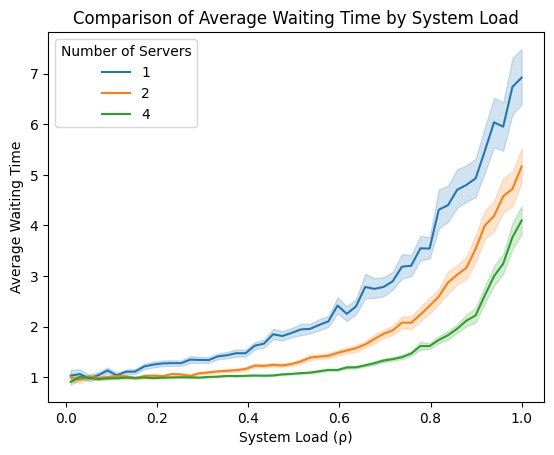

In [6]:
# Define parameters
SIM_TIME = 100
SIMULATIONS = 200
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # For example, number of servers are 1, 2, and 4

# Run simulations and collect results
simulation_results = [run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# Prepare data
plot_df = prepare_plot_data(simulation_results, server_configs)

# Plot data
plot_data(plot_df)


**Verification of normal distribution**

In [4]:
# Plot histogram or density plot
def plt_distribution(all_sim_data, title, xlabel = 'Waiting Time'):
    """
    Plots a histogram or density plot for simulation data.
    Args:
        all_sim_data: Data for all simulations.
        title: Title for the plot.
        xlabel: Label for the x-axis (default is 'Waiting Time').
    """
    sns.histplot(all_sim_data, kde=True, stat='density', bins=200)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.show()
    

# Plot overlaid histogram or density plot
def plt_distribution_group(sim_data_group, title, labels, xlabel='Average Waiting Time'):
    """
    Plots overlaid histograms or density plots for grouped simulation data.
    Args:
        sim_data_group: Group of simulation data.
        title: Title for the plot.
        labels: Labels for each group in the plot.
        xlabel: Label for the x-axis (default is 'Average Waiting Time').
    """
    for group_data, label in zip(sim_data_group, labels):
        sns.histplot(group_data, kde=True, stat='density', bins=200, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def prepare_group_data(sim_data):
    """
    Prepares group data by consolidating all waiting times from simulation results into one list.
    Args:
        sim_data: Simulation data from which to extract waiting times.
    Returns:
        List of all waiting times from the simulation data.
    """
    # Consolidate all waiting times from simulation results into one list
    all_waiting_times = []
    for data in sim_data:
        all_waiting_times.extend(data)

    return all_waiting_times


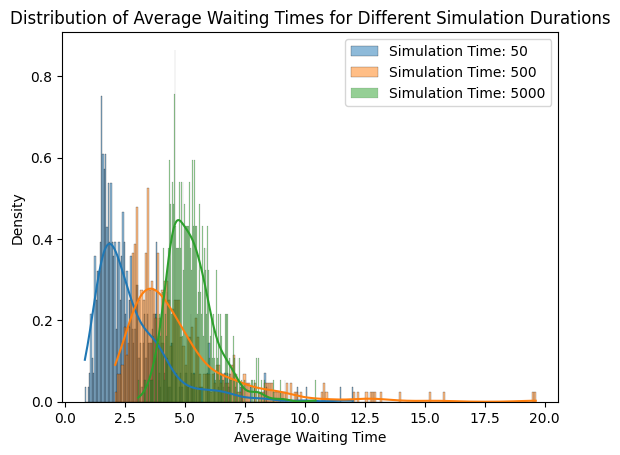

In [9]:
# Define simulation parameters
num_servers = 2  # Number of servers
rho = 0.9  # System load
MU = 1  # Service rate
SIMULATIONS = 500  # Number of simulations
SIM_TIMES = [50, 500, 5000]  # Different simulation durations

# Run simulations and collect results
simulation_results = []
for SIM_TIME in SIM_TIMES:
    _, avg_waitings = run_simulation(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
    simulation_results.append(avg_waitings)

# Define labels
labels = [f'Simulation Time: {SIM_TIME}' for SIM_TIME in SIM_TIMES]

# Plot results
plt_distribution_group(simulation_results, "Distribution of Average Waiting Times for Different Simulation Durations", labels)


**Hypothesis testing**

############  rho = 0.5
SIMULATIONS = 20
0.0371859007594784 0.05216832376446854
SIMULATIONS = 21
0.03819705249710457 0.03475708371182139
############  rho = 0.5544444444444444
SIMULATIONS = 20
0.03989720350238506 0.03395811272846805
############  rho = 0.6088888888888889
SIMULATIONS = 20
0.038577941244458513 0.04613679210486594
############  rho = 0.6633333333333333
SIMULATIONS = 20
0.029249429800581504 0.03840356999369427
############  rho = 0.7177777777777777
SIMULATIONS = 20
0.04330840173579824 0.03029564292624761
############  rho = 0.7722222222222221
SIMULATIONS = 20
0.02250185478137382 0.04717271265316775
############  rho = 0.8266666666666667
SIMULATIONS = 20
0.04380554194097198 0.06945701491007097
SIMULATIONS = 21
0.08391887185511984 0.029810148516712643
SIMULATIONS = 22
0.03782154369500447 0.13830696794891478
SIMULATIONS = 23
0.08260411528255134 0.04641051715756927
SIMULATIONS = 24
0.0310134303065966 0.05199593261905776
SIMULATIONS = 25
0.05820104363726338 0.04013769595462932


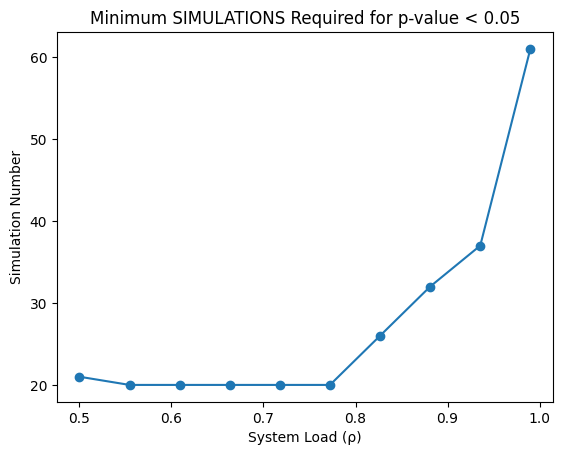

In [15]:
def simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS):
    p_4_vs_2_list = []
    p_2_vs_1_list = []
    for _ in range(20):
        # Run simulation and collect data
        _, avg_waitings_1_server = run_simulation(1, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_2_servers = run_simulation(2, rho, MU, SIM_TIME, SIMULATIONS)
        _, avg_waitings_4_servers = run_simulation(4, rho, MU, SIM_TIME, SIMULATIONS)

        # Perform Mann-Whitney U test
        u_stat_4_vs_2, p_4_vs_2 = perform_mann_whitney_u_test(avg_waitings_4_servers, avg_waitings_2_servers)
        u_stat_2_vs_1, p_2_vs_1 = perform_mann_whitney_u_test(avg_waitings_2_servers, avg_waitings_1_server)

        p_4_vs_2_list.append(p_4_vs_2)
        p_2_vs_1_list.append(p_2_vs_1)
    
    p_4_vs_2_mean = np.mean(p_4_vs_2_list)
    p_2_vs_1_mean = np.mean(p_2_vs_1_list)

    return p_4_vs_2_mean, p_2_vs_1_mean

SIM_TIME = 50
MU = 1
rhos = np.linspace(0.5, 0.99, 10)
simulation_results = []

for rho in rhos:
    SIMULATIONS = 20
    print(f"############  rho = {rho}")
    while True:
        print(f"SIMULATIONS = {SIMULATIONS}")
        p_4_vs_2_mean, p_2_vs_1_mean = simulation_and_test(rho, MU, SIM_TIME, SIMULATIONS)
        print(p_4_vs_2_mean, p_2_vs_1_mean)
        if p_4_vs_2_mean < 0.05 and p_2_vs_1_mean < 0.05:
            break
        SIMULATIONS += 1
    simulation_results.append((rho, SIMULATIONS))

# Plot graph
rhos, sims = zip(*simulation_results)
plt.plot(rhos, sims, marker='o')
plt.title("Minimum SIMULATIONS Required for p-value < 0.05")
plt.xlabel("System Load (ρ)")
plt.ylabel("Simulation Number")
plt.show()

#### How variance change when ρ change

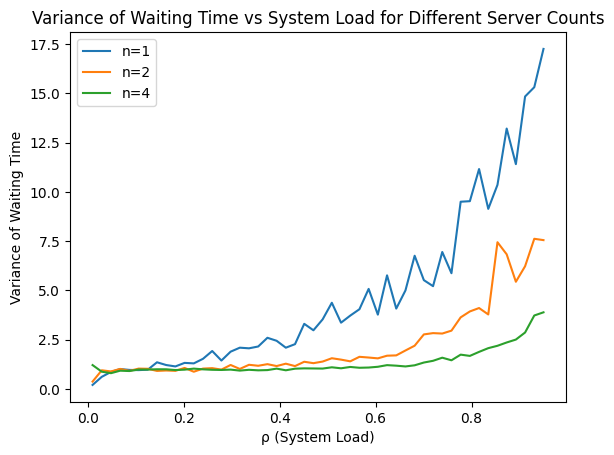

In [5]:
def run_simulation_with_variance(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # Arrival rate

    variances = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        variance = np.var(waiting_times)
        variances.append(variance)
    return np.mean(variances)

# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 50  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHOS = np.linspace(0.01, 0.95, 50)  # System load

# Dictionary to store variances for different server numbers and rhos
variances = {num_servers: [] for num_servers in SERVERS}

# Run simulations and collect variances
for num_servers in SERVERS:
    for rho in RHOS:
        variance = run_simulation_with_variance(num_servers, rho, MU, SIM_TIME, SIMULATIONS)
        variances[num_servers].append(variance)

# Plotting the variances
for num_servers, variance_data in variances.items():
    plt.plot(RHOS, variance_data, label=f'n={num_servers}')
plt.xlabel('ρ (System Load)')
plt.ylabel('Variance of Waiting Time')
plt.title('Variance of Waiting Time vs System Load for Different Server Counts')
plt.legend()
plt.show()

## Problem 3 - Compare M/M/1 queue with shortest job first scheduling

#### Simulation for M/M/1 with shortest job first scheduling

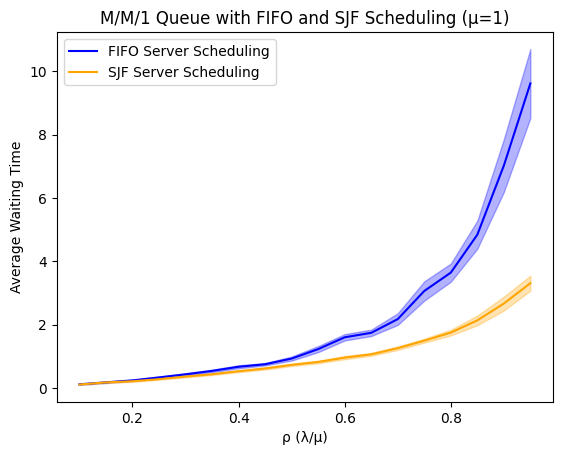

In [22]:
# Comparison between M/M/1 and shortest job first scheduling under varying Rho (with fixed MU)
# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    """
    Calculates the confidence interval.
    Args:
        mean: Mean of the data.
        std_dev: Standard deviation of the data.
        n: Sample size.
        p: Confidence level (default 0.95).
    Returns:
        Lower and upper bounds of the confidence interval.
    """
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Adjusted job_generator to accept lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    """
    Generates jobs with a given arrival rate.
    Args:
        env: Simulation environment.
        server: Server resource.
        waiting_times: List to record waiting times.
        lambda_val: Arrival rate of jobs.
    """
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(MU)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    """
    Processes a job in the simulation.
    Args:
        env: Simulation environment.
        job: Job to be processed.
        server: Server resource.
        waiting_times: List to record waiting times.
    """
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)  # For SJF, request with job's service time as priority.
    else:
        request = server.request() # For FIFO, regular request without priority.
    
    with request as req:
        yield req # Wait for the server to be available.
        wait = env.now - job.arrive_time # Calculate waiting time.
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Class Job with added service_time parameter
class Job:
    """
    Represents a job in the simulation.
    Attributes:
        name: Name of the job.
        arrive_time: Arrival time of the job.
        service_time: Service time of the job.
    """
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted run_simulation to accept lambda_val and pass it to job_generator
def run_simulation_sjfs(server_type, lambda_val):
    """
    Runs the simulation for a specified server type and arrival rate.
    Args:
        server_type: Type of the server ('SJF' or 'FIFO').
        lambda_val: Arrival rate of jobs.
    Returns:
        Average waiting time for this simulation.
    """
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)  # Return the average waiting time for this simulation


# Parameters
MU = 1  # Fixed service rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging

# Prepare a range of rho values
rhos = np.arange(0.1, 1.0, 0.05)
results = []

for rho in rhos:
    lambda_val = rho * MU
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server Scheduling', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('ρ (λ/μ)')
plt.ylabel('Average Waiting Time')
plt.title('M/M/1 Queue with FIFO and SJF Scheduling (μ=1)')
plt.legend()
plt.show()

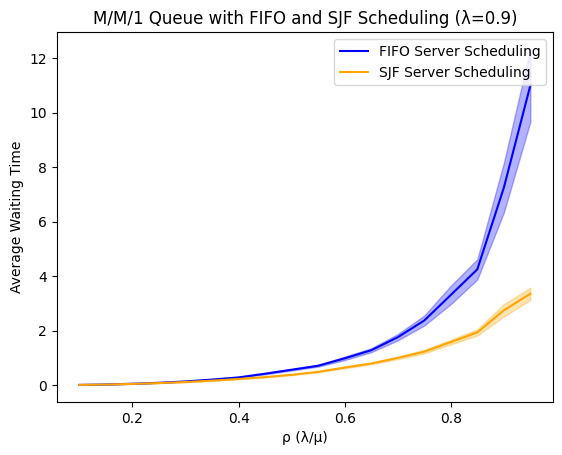

In [23]:
# Adjusted job_generator to accept mu_val
def job_generator(env, server, waiting_times, lambda_val, mu_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(mu_val)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation to accept mu_val and pass it to job_generator
def run_simulation_sjfs(server_type, lambda_val, mu_val):
    env = simpy.Environment()
    waiting_times = []
    if server_type == 'SJF':
        server = simpy.PriorityResource(env, capacity=1)
    else:
        server = simpy.Resource(env, capacity=1)
    
    env.process(job_generator(env, server, waiting_times, lambda_val, mu_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Fixed parameters
LAMBDA = 0.9  # Fixed arrival rate
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging

# Prepare a range of rho values and calculate corresponding mu values
rhos = np.arange(0.1, 1.0, 0.05)
results = []

for rho in rhos:
    mu_val = LAMBDA / rho  # Calculate mu for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, LAMBDA, mu_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server Scheduling', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('ρ (λ/μ)')
plt.ylabel('Average Waiting Time')
plt.title('M/M/1 Queue with FIFO and SJF Scheduling (λ=0.9)')
plt.legend()
plt.show()

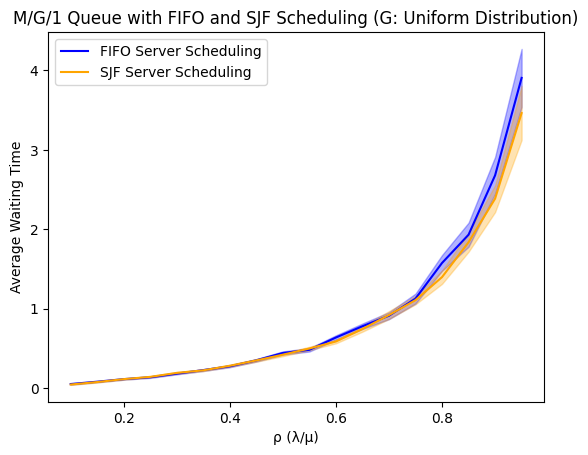

In [24]:
# Adjusted job_generator for consistent job lengths and lambda_val
def job_generator(env, server, waiting_times, lambda_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.uniform(0.9, 1.0)  # Consistent job lengths
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted run_simulation
def run_simulation_sjfs(server_type, lambda_val):
    env = simpy.Environment()
    waiting_times = []
    server = simpy.PriorityResource(env, capacity=1) if server_type == 'SJF' else simpy.Resource(env, capacity=1)
    env.process(job_generator(env, server, waiting_times, lambda_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)

# Parameters
MU = 1  # Fixed service rate (MU)
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging
rhos = np.arange(0.1, 1.0, 0.05)  # Range of rho values

# Run the simulation
results = []
for rho in rhos:
    lambda_val = rho * MU  # Calculate lambda for each rho
    for queue_type in ['FIFO', 'SJF']:
        avg_wait_times = []
        for _ in range(SIMULATIONS):
            avg_wait_time = run_simulation_sjfs(queue_type, lambda_val)
            avg_wait_times.append(avg_wait_time)
        mean_wait = np.mean(avg_wait_times)
        std_dev_wait = np.std(avg_wait_times, ddof=1)
        conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
        results.append({
            'Rho': rho, 'QueueType': queue_type, 
            'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
            'ConfIntervalUpper': conf_upper
        })

# Convert results to DataFrame and plot
results_df = pd.DataFrame(results)

# Plotting
colors = ['blue', 'orange']  # Define colors for the different lines, adjust as needed for your categories

for i, queue_type in enumerate(['FIFO', 'SJF']):
    subset = results_df[results_df['QueueType'] == queue_type]
    # Plot the mean waiting time line
    plt.plot(subset['Rho'], subset['MeanWait'], label=f'{queue_type} Server Scheduling', color=colors[i])
    # Fill between the upper and lower confidence interval bounds
    plt.fill_between(subset['Rho'],
                     subset['ConfIntervalLower'],
                     subset['ConfIntervalUpper'],
                     color=colors[i], alpha=0.3)  # Adjust alpha for transparency

plt.xlabel('ρ (λ/μ)')
plt.ylabel('Average Waiting Time')
plt.title('M/G/1 Queue with FIFO and SJF Scheduling (G: Uniform Distribution)')
plt.legend()
plt.show()

#### 3D plot of waiting time

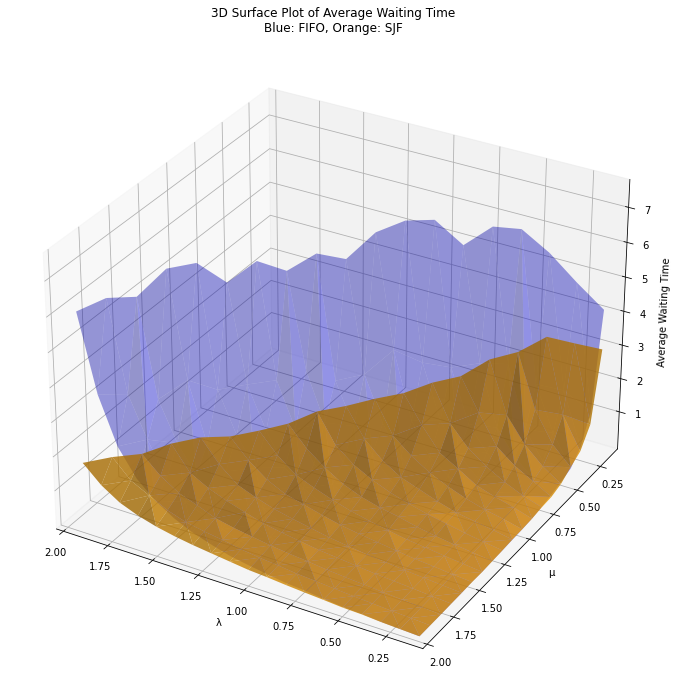

In [3]:
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D

# Function for confidence interval calculation
def conf_int(mean, std_dev, n, p=0.95):
    z_value = st.norm.ppf((p + 1) / 2)
    margin = (z_value * std_dev) / math.sqrt(n)
    return mean - margin, mean + margin

# Adjusted job_generator to accept lambda_val and mu_val
def job_generator(env, server, waiting_times, lambda_val, mu_val):
    job_count = 0
    while True:
        yield env.timeout(random.expovariate(lambda_val))
        job_count += 1
        service_time = random.expovariate(mu_val)
        job = Job(f'Job_{job_count}', env.now, service_time)
        env.process(serve(env, job, server, waiting_times))

# Adjusted serve to create job with service_time
def serve(env, job, server, waiting_times):
    if isinstance(server, simpy.PriorityResource): 
        request = server.request(priority=job.service_time)  # For SJF, request with job's service time as priority.
    else:
        request = server.request() # For FIFO, regular request without priority.
    
    with request as req:
        yield req # Wait for the server to be available.
        wait = env.now - job.arrive_time # Calculate waiting time.
        waiting_times.append(wait)
        yield env.timeout(job.service_time)

# Class Job with added service_time parameter
class Job:
    def __init__(self, name, arrive_time, service_time):
        self.name = name
        self.arrive_time = arrive_time
        self.service_time = service_time

# Adjusted run_simulation to accept lambda_val and mu_val
def run_simulation_3D(server_type, lambda_val, mu_val):
    env = simpy.Environment()
    waiting_times = []
    server = simpy.PriorityResource(env, capacity=1) if server_type == 'SJF' else simpy.Resource(env, capacity=1)
    env.process(job_generator(env, server, waiting_times, lambda_val, mu_val))
    env.run(until=SIM_TIME)
    return np.mean(waiting_times)  # Return the average waiting time for this simulation

# Parameters
SIM_TIME = 500  # Simulation time in time units
SIMULATIONS = 100  # Number of simulations for averaging
MU_values = np.arange(0.1, 2.1, 0.1)  # Example range for MU
Lambda_values = np.arange(0.1, 2.1, 0.1)  # Example range for Lambda

# Run the simulation
results = []

for MU in MU_values:
    for Lambda in Lambda_values:
        # Ensure that rho (Lambda / MU) is less than 1
        if Lambda < MU:  # This ensures that rho < 1
            for queue_type in ['FIFO', 'SJF']:
                avg_wait_times = []
                for _ in range(SIMULATIONS):
                    avg_wait_time = run_simulation_3D(queue_type, Lambda, MU)
                    avg_wait_times.append(avg_wait_time)
                mean_wait = np.mean(avg_wait_times)
                std_dev_wait = np.std(avg_wait_times, ddof=1)
                conf_lower, conf_upper = conf_int(mean_wait, std_dev_wait, SIMULATIONS)
                results.append({
                    'MU': MU, 'Lambda': Lambda, 'QueueType': queue_type, 
                    'MeanWait': mean_wait, 'ConfIntervalLower': conf_lower, 
                    'ConfIntervalUpper': conf_upper
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create the 3D plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for queue_type in ['FIFO', 'SJF']:
    subset = results_df[results_df['QueueType'] == queue_type]
    if queue_type == 'SJF':
        # Non-transparent surface for SJF
        ax.plot_trisurf(subset['Lambda'], subset['MU'], subset['MeanWait'], color='orange', alpha=0.8, label='SJF')
    else:
        # Transparent surface for FIFO
        ax.plot_trisurf(subset['Lambda'], subset['MU'], subset['MeanWait'], color='blue', alpha=0.4, label='FIFO')

    
ax.set_xlim([2.0, 0.1])
ax.set_ylim([2.0, 0.1])
ax.set_xlabel('λ')
ax.set_ylabel('μ')
ax.set_zlabel('Average Waiting Time')
ax.set_title('3D Surface Plot of Average Waiting Time\nBlue: FIFO, Orange: SJF')

plt.show()


## Problem 4 - The M/D/1 and M/D/n queues and long tail distribution

#### Simulation for M/D/1 and M/D/n

In [18]:
# Initialize the simulation environment and customer arrival process
def setup_MDn(env, num_servers, servicetime, Lambda, waiting_times):
    """
    Sets up the simulation environment with a specified number of servers.
    Args:
        env: The simulation environment.
        num_servers: Number of servers/resources available.
        servicetime: Average service time.
        Lambda: Rate of customer arrival.
        waiting_times: List to record the waiting times of customers.
    """
    # Create server resources
    server = simpy.Resource(env, num_servers)

    def service(customer):
        """ Service process with service time following an exponential distribution. """
        yield env.timeout(servicetime)

    def customer(name):
        """ Customer arrival and service process. """
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            # Record each customer's waiting time
            waiting_times.append(waiting_time)
    
    # Generate initial customer
    env.process(customer('Customer 0'))

    # Continuously generate customers
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

# Simulation run function
def run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    """
    Runs the simulation for a multi-server queue system.
    Args:
        num_servers: Number of servers.
        rho: Traffic intensity.
        MU: Service rate.
        SIM_TIME: Total simulation time.
        SIMULATIONS: Number of simulations to run.
    Returns:
        Tuple of simulation data and average waiting times.
    """
    servicetime = 1/MU
    Lambda = rho * (MU * num_servers)  # Arrival rate
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_MDn(env, num_servers, servicetime, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [19]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          1.052381   
1             2  0.10          1.004489   
2             4  0.10          1.000305   
3             1  0.50          1.483164   
4             2  0.50          1.165891   
5             4  0.50          1.052415   
6             1  0.90          3.557962   
7             2  0.90          2.683508   
8             4  0.90          1.792196   
9             1  0.99          5.669557   
10            2  0.99          3.747149   
11            4  0.99          2.885214   

                                     all_waiting_time  \
0   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
2   [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
3   [[1.0, 1.0, 1.0, 1.8455121176120155, 1.6912118...   
4   [[1.0, 1.0000000000000002, 1.0, 1.793355335998...   
5   [[1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0,...   
6   [[1.0, 1.0, 1.3829296580689547, 1.983

In [20]:
# Plot the impact of system load (ρ) on average waiting time

def run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    """
    Runs simulations for multiple server configurations across a range of system loads.
    Args:
        num_servers: Number of servers in the simulation.
        rhos: Array of system load values (ρ) to simulate.
        MU: Service rate.
        SIM_TIME: Total simulation time.
        SIMULATIONS: Number of simulations to run.
    Returns:
        Dictionary with system load as key and average waiting times as values.
    """
    return {rho: run_simulation_MDn(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

def prepare_plot_data(simulation_results, server_configs):
    """
    Prepares data for plotting by creating a DataFrame.
    Args:
        simulation_results: Results from run_simulations_MDn.
        server_configs: List of server configurations used in the simulations.
    Returns:
        DataFrame with system load, average waiting time, and number of servers.
    """
    plot_data = {'rho': [], 'avg_waiting_time': [], 'num_servers': []}
    
    for num_servers, all_waiting_times in zip(server_configs, simulation_results):
        for rho, waiting_times in all_waiting_times.items():
            plot_data['rho'].extend([rho] * len(waiting_times))
            plot_data['avg_waiting_time'].extend(waiting_times)
            plot_data['num_servers'].extend([str(num_servers)] * len(waiting_times))
    
    return pd.DataFrame(plot_data)

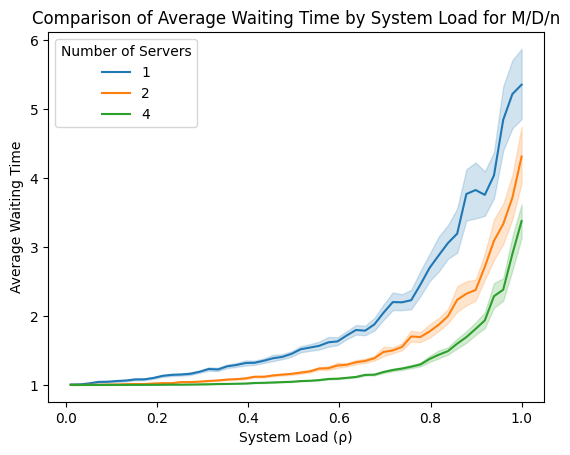

In [21]:
# Define parameters
SIM_TIME = 100
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 50)
server_configs = [1, 2, 4]  # For example, number of servers are 1, 2, and 4

# Run simulations and collect results
simulation_results = [run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# Prepare data
plot_df = prepare_plot_data(simulation_results, server_configs)

# Plot data
plot_data(plot_df, "Comparison of Average Waiting Time by System Load for M/D/n")

#### Simulation for long tail distribution

In [25]:
import simpy
import numpy as np
import pandas as pd
from scipy import stats

def setup_tail(env, num_servers, Lambda, waiting_times):
    """
    Sets up the simulation environment with tail distribution for service times.
    Args:
        env: Simulation environment.
        num_servers: Number of servers/resources available.
        Lambda: Rate of customer arrival.
        waiting_times: List to record the waiting times of customers.
    """
    server = simpy.Resource(env, num_servers)

    def service(customer):
        # Randomly select service time distribution
        if np.random.rand() < 0.75:  # 75% of the time, use exponential distribution with average service time of 1.0
            yield env.timeout(np.random.exponential(1.0))
        else:  # Remaining 25% of the time, use exponential distribution with average service time of 5.0
            yield env.timeout(np.random.exponential(5.0))

    def customer(name):
        arrival_time = env.now
        with server.request() as request:
            yield request
            yield env.process(service(name))
            waiting_time = env.now - arrival_time
            waiting_times.append(waiting_time)
    
    while True:
        yield env.timeout(np.random.exponential(1/Lambda))
        env.process(customer(f'Customer {env.now}'))

def run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS):
    """
    Runs the simulation with tail distribution for service times.
    Args:
        num_servers: Number of servers.
        rho: Traffic intensity.
        MU: Service rate.
        SIM_TIME: Total simulation time.
        SIMULATIONS: Number of simulations to run.
    Returns:
        Tuple of simulation data and average waiting times.
    """
    Lambda = rho * (MU * num_servers)
    
    data_sims = []
    avg_waitings = []
    for _ in range(SIMULATIONS):
        env = simpy.Environment()
        waiting_times = []
        env.process(setup_tail(env, num_servers, Lambda, waiting_times))
        env.run(until=SIM_TIME)
        avg_waiting = np.mean(waiting_times)
        data_sims.append(waiting_times)
        avg_waitings.append(avg_waiting)
    return data_sims, avg_waitings


In [26]:
# Simulation parameters
MU = 1  # Service rate
SIM_TIME = 100  # Simulation duration
SIMULATIONS = 100  # Number of simulations
SERVERS = [1, 2, 4]  # Number of servers
RHO = [0.1, 0.5, 0.9, 0.99]  # System load

# Store all simulation results
all_sim_data = []

# Run simulations for each server count and system load
for rho in RHO:
    for num_servers in SERVERS:
        sim_data, avg_waitings = run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)  # Waiting time for each individual
        all_sim_data.append({
            'num_servers': num_servers,
            'rho': rho,
            'avg_waiting_time': np.mean(avg_waitings),
            'all_waiting_time': sim_data,
            '95%_confidence_interval': stats.norm.interval(0.95, loc=np.mean(avg_waitings), scale=stats.sem(avg_waitings)),
            'Simtime': SIM_TIME
        })

# Convert results to DataFrame and save to CSV file
results_df = pd.DataFrame(all_sim_data)
print(results_df)
results_df.to_csv('simulation_results.csv', index=False)


    num_servers   rho  avg_waiting_time  \
0             1  0.10          2.339611   
1             2  0.10          1.872381   
2             4  0.10          1.858250   
3             1  0.50         10.552922   
4             2  0.50          8.278103   
5             4  0.50          6.455527   
6             1  0.90         22.707247   
7             2  0.90         22.891495   
8             4  0.90         21.420852   
9             1  0.99         25.403496   
10            2  0.99         24.811850   
11            4  0.99         25.035854   

                                     all_waiting_time  \
0   [[0.2850197264473282, 0.43405575354099746, 1.1...   
1   [[0.7518411027293528, 20.645492310272644, 0.62...   
2   [[1.1785622553435418, 0.7112474201101051, 3.35...   
3   [[0.20013884020539863, 1.1702237030851927, 0.7...   
4   [[0.0016964627687205414, 0.6947890714375795, 0...   
5   [[0.29518291952905085, 0.16790569901681152, 1....   
6   [[0.30814942501793163, 1.121363638249

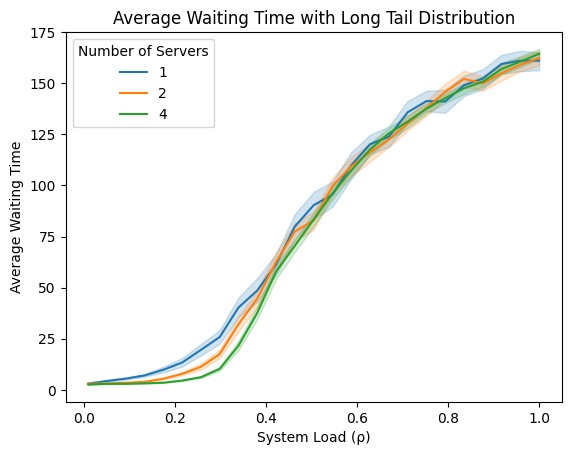

In [46]:
def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    # Runs simulations for each rho value and returns average waiting times
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# Define parameters
SIM_TIME = 500
SIMULATIONS = 100
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs = [1, 2, 4]  # For example, number of servers are 1, 2, and 4

# Run simulations and collect results
simulation_results = [run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS) for num_servers in server_configs]

# Prepare data
plot_df = prepare_plot_data(simulation_results, server_configs)

# Plot data
plot_data(plot_df, "Average Waiting Time with Long Tail Distribution")


#### Comparison between M/M/n and M/D/n

C:\Users\liaojw\AppData\Local\Temp\ipykernel_12736\88074407.py:3: UserWarning: 
The dashes list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df2, x='rho', y='avg_waiting_time', hue='num_servers', style='num_servers', dashes=[(2, 2)], palette=['b', 'g', 'r'])


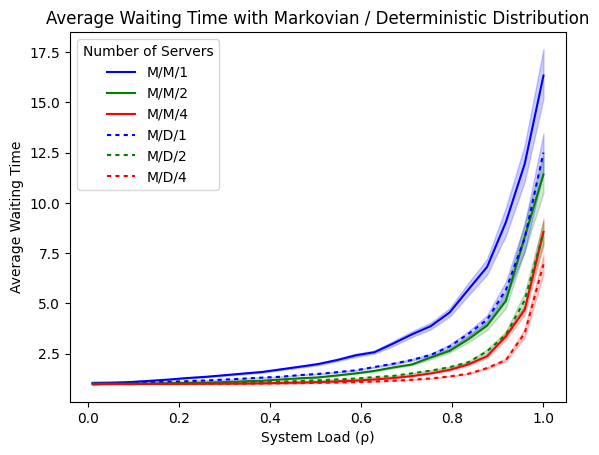

In [47]:
def plot_data_for_2df(df1, df2, title = "Average Waiting Time with Markovian / Deterministic Distribution"):
    # Plot data for two dataframes with distinct styles
    sns.lineplot(data=df1, x='rho', y='avg_waiting_time', hue='num_servers', style='num_servers', dashes=False, palette=['b', 'g', 'r'])
    sns.lineplot(data=df2, x='rho', y='avg_waiting_time', hue='num_servers', style='num_servers', dashes=[(2, 2)], palette=['b', 'g', 'r'])
    
    plt.title(title)
    plt.xlabel('System Load (ρ)')
    plt.ylabel('Average Waiting Time')
    plt.legend(title='Number of Servers')
    plt.show()

def run_simulations_tail(num_servers, rhos, MU, SIM_TIME, SIMULATIONS):
    # Runs simulations and returns average waiting times for each rho value
    return {rho: run_simulation_tail(num_servers, rho, MU, SIM_TIME, SIMULATIONS)[1] for rho in rhos}

# Define parameters
SIM_TIME = 500
SIMULATIONS = 200
MU = 1
rhos = np.linspace(0.01, 1, 25)
server_configs1 = ["M/M/1", "M/M/2", "M/M/4"]  # Labels for the plots
server_configs2 = ["M/D/1", "M/D/2", "M/D/4"]

simulation_results1 = []
simulation_results2 = []

# Run simulations and collect results
num_servers = 1
simulation_results1.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results2.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
num_servers = 2
simulation_results1.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results2.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
num_servers = 4
simulation_results1.append(run_simulations(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))
simulation_results2.append(run_simulations_MDn(num_servers, rhos, MU, SIM_TIME, SIMULATIONS))

# Prepare data
plot_df1 = prepare_plot_data(simulation_results1, server_configs1)
plot_df2 = prepare_plot_data(simulation_results2, server_configs2)

# Plot data
plot_data_for_2df(plot_df1, plot_df2)
